# Turing Target Practice

## Model

In [14]:
] activate "."

  Activating project at `~/Glamdring/MicroCanonicalHMC.jl`


In [15]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [16]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [17]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [18]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm  ~ Uniform(0.01, 0.6)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [19]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [28]:
target = TuringTarget(stat_model);

In [29]:
spl = MCHMC(0.0, 0.0; init_eps=0.07, varE_wanted=0.01, sigma=ones(2))
samples_mchmc = Sample(spl, target, 100_000;
                       burn_in=10_000,  
                       file_name="Turing_sequential_samples",
                       dialog=true);

Initial Virial loss: 39.63306067192312
Virial loss: 

[ Info: Using given sigma ✅
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Starting burn in ⏳


11.207938132976949 --> Relative improvement: 0.7803152785803469
Virial loss: 16.890917206638314 --> Relative improvement: 0.5070494685316311
Virial loss: 23.377794486939422 --> Relative improvement: 0.38404529493233763
Virial loss: 30.516413897651972 --> Relative improvement: 0.3053589770711995
Virial loss: 37.15386195818659 --> Relative improvement: 0.21750419570254031
Virial loss: 36.78417675646762 --> Relative improvement: 0.009950115068388166
Using eps tuning method AdaptiveStep


[ Info: Virial loss condition met during burn-in at step: 6


eps: 0.07 --> VarE/d: 3.205441141209311
eps: 0.030390168030949644 --> VarE/d: 0.6030309060800092
eps: 0.02113302219595307 --> VarE/d: 0.28923199763345886
eps: 0.01713559345464571 --> VarE/d: 0.18747297128618595
eps: 0.014887737299651729 --> VarE/d: 0.13946695775517323
eps: 0.013430018688250864 --> VarE/d: 0.10284663956843702
eps: 0.012428084409683638 --> VarE/d: 0.09036214117315033
eps: 0.01166304206147998 --> VarE/d: 0.06984925886656594
eps: 0.011093130908659389 --> VarE/d: 0.07622945202139125
eps: 0.010586574029273474 --> VarE/d: 0.07272079496005845
eps: 0.01015476395309992 --> VarE/d: 0.06367247335498419
eps: 0.00979590568040169 --> VarE/d: 0.058584677414904425
eps: 0.009487296848196578 --> VarE/d: 0.055196551091765474
eps: 0.009216126668042527 --> VarE/d: 0.05044242482045851
eps: 0.008980060520268387 --> VarE/d: 0.04651860896710041
eps: 0.008772402036617798 --> VarE/d: 0.0471024073372897
eps: 0.008578025785090074 --> VarE/d: 0.04344989717671878
eps: 0.008405319239221878 --> VarE/d:

[ Info: Found eps: 0.005651854282797111 ✅


samples: 100--> 1/<1/ess>: 0.016570786890202003
samples: 203--> 1/<1/ess>: 0.00799870556382242
samples: 310--> 1/<1/ess>: 0.004550600914339857
samples: 420--> 1/<1/ess>: 0.00337100933019014
samples: 534--> 1/<1/ess>: 0.0030093537194203048
samples: 652--> 1/<1/ess>: 0.003250696220440207
samples: 774--> 1/<1/ess>: 0.003492760890797783
samples: 900--> 1/<1/ess>: 0.0038375975147395217
samples: 1030--> 1/<1/ess>: 0.004167634639016512
samples: 1164--> 1/<1/ess>: 0.0045688202797288646
samples: 1302--> 1/<1/ess>: 0.004587397702791656
samples: 1445--> 1/<1/ess>: 0.004555370353220112
samples: 1593--> 1/<1/ess>: 0.00433617541527515
samples: 1746--> 1/<1/ess>: 0.004222459048041107
samples: 1904--> 1/<1/ess>: 0.004267652681598328
samples: 2067--> 1/<1/ess>: 0.004244340932396429
samples: 2235--> 1/<1/ess>: 0.004097707679511957
samples: 2409--> 1/<1/ess>: 0.004071523202487775
samples: 2589--> 1/<1/ess>: 0.004290253249509835


[ Info: Found L: 0.5269483132207023 ✅


In [30]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

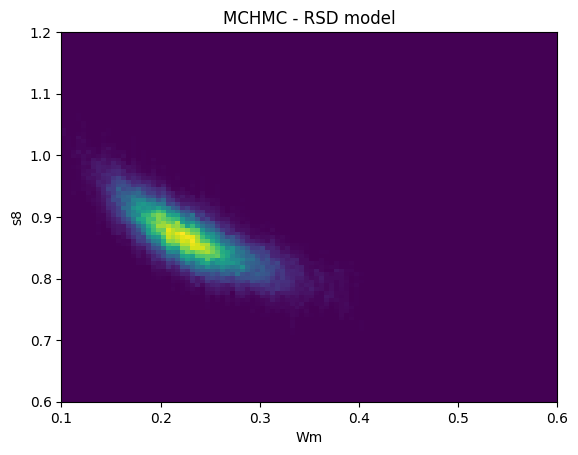

In [31]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

In [38]:
spl = MCHMC(0.0, 0.0, 10; init_eps=0.07, varE_wanted=0.1)
samples_ensemble_mchmc = Sample(spl, target, 10000;
                                burn_in=1000,
                                monitor_energy=true, 
                                dialog=true);

Initial Virial loss: 4744.227858152637
Virial loss: 42.7586477383604 --> Relative improvement: 0.3792150317759553
Sigma --> [1.2722974784738743, 0.2372932134857158]
Virial loss: 39.2515324516098 --> Relative improvement: 0.08202119272364727
Sigma --> [1.2557892797224894, 0.22102714969293222]
Virial loss: 37.052471325484106 --> Relative improvement: 0.05602484766261662
Sigma --> [1.2436445392012587, 0.21045321691862828]
Virial loss: 34.9991698805144 --> Relative improvement: 0.055416045718858054
Sigma --> [1.2333547802262945, 0.20226861085372114]
Virial loss: 32.3640649218634 --> Relative improvement: 0.07529049882174721
Sigma --> [1.2242264998960666, 0.19533491336946482]
Virial loss: 29.757548523084758 --> Relative improvement: 0.08053736157900937
Sigma --> [1.2157514113682168, 0.1891920861719633]
Virial loss: 27.09748787014015 --> Relative improvement: 0.08939112208389866
Sigma --> [1.2072361450877536, 0.18362740419556725]
Virial loss: 24.642467214605006 --> Relative improvement: 0.09

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Starting burn in ⏳
[ Info: Virial loss condition met during burn-in at step: 11
[ Info: Found sigma: [1.1711941149565837, 0.16533407002968975] ✅


eps: 0.028448483176316323 --> VarE/d: 0.15047438873037625
eps: 0.02823298993510771 --> VarE/d: 0.1427111352485883
eps: 0.028059212529818363 --> VarE/d: 0.13082632738310213
eps: 0.027936493561429195 --> VarE/d: 0.11759380574326754
eps: 0.02786677693803468 --> VarE/d: 0.10871031297669238
eps: 0.02783272307463728 --> VarE/d: 0.0969983439067346
samples: 100--> 1/<1/ess>: 70.9598128093146


[ Info: Found eps: 0.02783272307463728 ✅
[ Info: Found L: 0.00015689287765981136 ✅


In [39]:
Wms_ensemble_mchmc = [sample[1] for sample in samples_ensemble_mchmc]
s8s_ensemble_mchmc = [sample[2] for sample in samples_ensemble_mchmc];

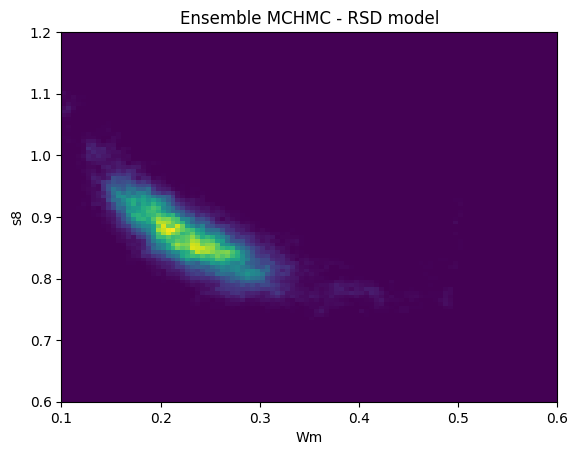

In [40]:
plt.hist2d(Wms_ensemble_mchmc, s8s_ensemble_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("Ensemble MCHMC - RSD model");

##  AbstractMCMC

In [27]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 10000;
    dialog=true)

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳


LoadError: UndefVarError: `tune_sigma!` not defined

In [16]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

[ Info: Starting from previous run


LoadError: type Array has no field info

## Ensemble AbstractMCMC

In [16]:
samples = sample(stat_model, MCHMC(100), 1000, 100)

[ Info: Burn-in started ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
┌ Warning: L-tuning not Implemented
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:41
[ Info: Found L: 1.4142135623730951 ✅
[ Info: VarE condition met during eps tuning at step: 13
[ Info: Found eps: 0.008664620420202015 ✅
[ Info: Virial loss condition met during burn-in at step: 2
[ Info: Found sigma: [1.620616898256196, 0.2532292543539198] ✅
┌ Warning: Maximum number of steps reached during eps tuning
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:214
[ Info: Found eps: 0.0043824511407622386 ✅
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:04


Chains MCMC chain (100000×4×1 Array{Float64, 3}):

Iterations        = 1:1:100000
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 6.0 seconds
Compute duration  = 6.0 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2901    0.1673     0.0005    0.0088   233.6325    1.0001     ⋯
          σ8    0.7617    0.2533     0.0008    0.0133   232.2530    1.0074     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.0259    0.1396    0.2759    0.4387    0.5603
          σ8    0.3356    0.5914    0.7780    0.9295    1.2868


In [17]:
new_samples = sample(stat_model, MCHMC(100), 1000, 100; 
                     resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:03


Chains MCMC chain (100000×4×1 Array{Float64, 3}):

Iterations        = 1:1:100000
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 3.38 seconds
Compute duration  = 3.38 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2404    0.0736     0.0002    0.0040   224.4534    1.0585     ⋯
          σ8    0.8627    0.0653     0.0002    0.0035   226.0813    1.0283     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1345    0.1857    0.2350    0.2774    0.4314
          σ8    0.7524    0.8142    0.8569    0.9029    0.9855


## Parallelization

In [18]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

[ Info: number of chains: 4 smaller than number of threads: 10. Increase the number of chains to make full use of your threads.
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Tuning L ⏳
[ Info: Tuning L ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳


LoadError: TaskFailedException

[91m    nested task error: [39mDomainError with -0.33934227649544785:
    sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).
    Stacktrace:
      [1] [0m[1mthrow_complex_domainerror[22m[0m[1m([22m[90mf[39m::[0mSymbol, [90mx[39m::[0mFloat64[0m[1m)[22m
    [90m    @[39m [90mBase.Math[39m [90m./[39m[90m[4mmath.jl:33[24m[39m
      [2] [0m[1msqrt[22m
    [90m    @[39m [90m./[39m[90m[4mmath.jl:677[24m[39m[90m [inlined][39m
      [3] [0m[1m_broadcast_getindex_evalf[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:683[24m[39m[90m [inlined][39m
      [4] [0m[1m_broadcast_getindex[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:656[24m[39m[90m [inlined][39m
      [5] [0m[1mgetindex[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:610[24m[39m[90m [inlined][39m
      [6] [0m[1mmacro expansion[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:974[24m[39m[90m [inlined][39m
      [7] [0m[1mmacro expansion[22m
    [90m    @[39m [90m./[39m[90m[4msimdloop.jl:77[24m[39m[90m [inlined][39m
      [8] [0m[1mcopyto![22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:973[24m[39m[90m [inlined][39m
      [9] [0m[1mcopyto![22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:926[24m[39m[90m [inlined][39m
     [10] [0m[1mcopy[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:898[24m[39m[90m [inlined][39m
     [11] [0m[1mmaterialize[22m[0m[1m([22m[90mbc[39m::[0mBase.Broadcast.Broadcasted[90m{Base.Broadcast.DefaultArrayStyle{1}, Nothing, typeof(sqrt), Tuple{Vector{Float64}}}[39m[0m[1m)[22m
    [90m    @[39m [90mBase.Broadcast[39m [90m./[39m[90m[4mbroadcast.jl:873[24m[39m
     [12] [0m[1mtune_sigma![22m[0m[1m([22m[90msampler[39m::[0mMicroCanonicalHMC.Sampler, [90mtarget[39m::[0mTuringTarget; [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}[39m[0m[1m)[22m
    [90m    @[39m [35mMicroCanonicalHMC[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mtuning.jl:89[24m[39m
     [13] [0m[1mtune_sigma![22m
    [90m    @[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mtuning.jl:83[24m[39m[90m [inlined][39m
     [14] [0m[1mtune_hyperparameters[22m[0m[1m([22m[90msampler[39m::[0mMicroCanonicalHMC.Sampler, [90mtarget[39m::[0mTuringTarget, [90minit[39m::[0mTuple[90m{Vector{Float64}, Vector{Float64}, Float64, Vector{Float64}, Float64}[39m; [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}[39m[0m[1m)[22m
    [90m    @[39m [35mMicroCanonicalHMC[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mtuning.jl:155[24m[39m
     [15] [0m[1mmacro expansion[22m
    [90m    @[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mabstractmcmc.jl:220[24m[39m[90m [inlined][39m
     [16] [0m[1m(::MicroCanonicalHMC.var"#902#threadsfor_fun#95"{MicroCanonicalHMC.var"#902#threadsfor_fun#84#96"{Base.Pairs{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @[39m [35mMicroCanonicalHMC[39m [90m./[39m[90m[4mthreadingconstructs.jl:139[24m[39m
     [17] [0m[1m#902#threadsfor_fun[22m
    [90m    @[39m [90m./[39m[90m[4mthreadingconstructs.jl:106[24m[39m[90m [inlined][39m
     [18] [0m[1m(::Base.Threads.var"#1#2"{MicroCanonicalHMC.var"#902#threadsfor_fun#95"{MicroCanonicalHMC.var"#902#threadsfor_fun#84#96"{Base.Pairs{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:84[24m[39m

...and 3 more exceptions.


In [19]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true, 
    resume_from=samples)

[ Info: Starting from previous run


LoadError: MethodError: no method matching iterate(::Chains{Float64, AxisArrays.AxisArray{Float64, 3, Array{Float64, 3}, Tuple{AxisArrays.Axis{:iter, StepRange{Int64, Int64}}, AxisArrays.Axis{:var, Vector{Symbol}}, AxisArrays.Axis{:chain, UnitRange{Int64}}}}, Missing, NamedTuple{(:parameters, :internals), Tuple{Vector{Symbol}, Vector{Symbol}}}, NamedTuple{(:target, :sampler, :init, :start_time, :stop_time), Tuple{ParallelTarget, MicroCanonicalHMC.EnsembleSampler, Tuple{Tuple{Matrix{Float64}, Matrix{Float64}, Vector{Real}, Matrix{Real}, Vector{Float64}}, Tuple{Matrix{Real}, Vector{Float64}, Vector{Float64}}}, Float64, Float64}}})

[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Integer[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{<:Any, <:Dict}, Base.ValueIterator{<:Dict}}
[0m[90m   @[39m [90mBase[39m [90m[4mdict.jl:698[24m[39m
[0m  ...


## NUTS

In [28]:
typeof(zeros(2,2,2))

Array{Float64, 3}

In [20]:
samples_hmc = sample(stat_model, NUTS(10, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:07


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 11:1:10010
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 11.66 seconds
Compute duration  = 11.66 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2403    0.0683     0.0007    0.0017   1405.0343    1.0006    ⋯
          σ8    0.8637    0.0619     0.0006    0.0012   2356.8676    1.0002    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     

In [21]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 11:1:10010
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.195289  0.931189  15.6471   7.0  1.0  …  2.0  0.0  0.0471045  0.0471045
 0.194965  0.891184  16.194    3.0  1.0     1.0  0.0  0.0471045  0.0471045
 0.20792   0.883536  16.2748  15.0  1.0     3.0  0.0  0.0471045  0.0471045
 0.252361  0.838644  16.1968  31.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.251986  0.825046  16.0557   1.0  1.0     1.0  0.0  0.0471045  0.0471045
 0.24801   0.831916  16.1395   3.0  1.0  …  2.0  0.0  0.0471045  0.0471045
 0.195668  0.864144  15.9732  21.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.264617  0.863147  15.8853  19.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.272399  0.787847  15.258    7.0  1.0 

In [22]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

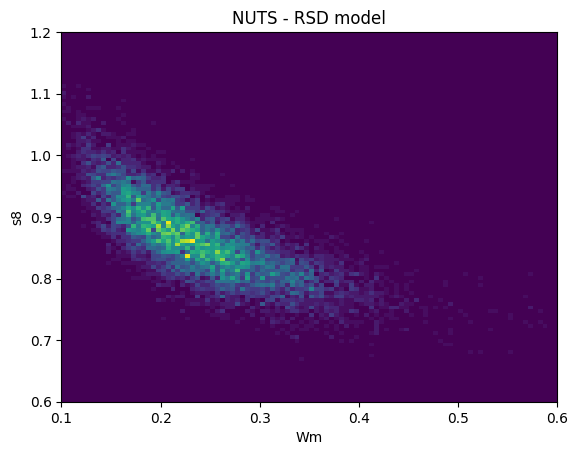

In [23]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("NUTS - RSD model");